## Installing Dependencies

In [3]:
# pip install --user -U scikit-learn scipy matplotlib wordcloud nltk numpy

  Using cached scikit_learn-1.2.0-cp39-cp39-win_amd64.whl (8.3 MB)
  Using cached scipy-1.9.3-cp39-cp39-win_amd64.whl (40.2 MB)
  Using cached matplotlib-3.6.2-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached wordcloud-1.8.2.2-cp39-cp39-win_amd64.whl (153 kB)
  Using cached nltk-3.8-py3-none-any.whl (1.5 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached contourpy-1.0.6-cp39-cp39-win_amd64.whl (161 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Import Dependencies

In [3]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# natural language toolkit
import nltk
from nltk.stem import WordNetLemmatizer

# sklean
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# one time downloads
#nltk.download('wordnet')
#nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...


True

## Import Dataset
The dataset being used is a sample Twitter dataset containing tweets extracted using **Twitter API**.  The tweets have been annotated **(0 = Negative, 4 = Positive)** and can be used to detect sentiment.  
**It contains the following 6 fields:**<br>
1. **sentiment**: Polarity of tweet (0 = negative, 4 = positive)
2. **id**'s: the id of the tweet
3. **date**: date of tweet in UTC
4. **flag**: the query (lyx).  If there is no query, the value is NO_QUERY
5. **user**: twitter handle of op
6. **text**: text of the tweet


We only require the **sentiment** and **text** fields, rest are discarded.  
We will also change **sentiment** field to new values where **0=negative, 1=positive**

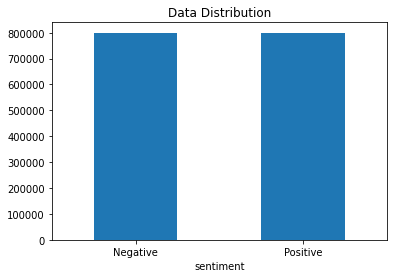

In [16]:
# Column Names
DATASET_COLUMNS = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../Sentiment_Analysis_Tweets_Data.csv',
                     encoding=DATASET_ENCODING,
                     names=DATASET_COLUMNS)
# Drop columns
dataset = dataset[['sentiment', 'text']]
# Replace sentiment values
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plot distribution
ax = dataset.groupby('sentiment').count().plot(kind='bar',
                                              title='Data Distribution',
                                              legend=False)
ax.set_xticklabels(['Negative','Positive'],
                  rotation=0)

# Sort data in lists
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## Preprocessing
**Steps taken are as follow**
1. **Lower Casing**: Convert each text to lowercase
2. **Replace URLs**: Link protocols are replaced with URL
3. **Replace Emojis**: Replace emojis using dictionary to text meaning such as :) to "EMOJIsmile"
4. **Replace Username**: Replace handles to "USER"
5. **Replace Non-Alphabets**: Replace characters except digits and alphabets with a space
6. **Remove Consecutive Lettrs**: 3 or more consecutive letters are replaced with 2 letters e.g. "heeeeyyyy" to "heeyy"
7. **Remove Short Words**: Words with length less than 2 are removed
8. **Remove Stopwords**: Stopwords are words that do not add meaning and can be ignored e.g. "the", "he", "have"
9. **Lemmatizing**: Lemmatization is process of converting word to base form e.g. "great" to "good"

In [17]:
# Define dictionary for emojis
emojis = {':)':'smile',':-)':'smile',';d':'wink',':-E':'vampire',':(':'sad',':-(':'sad',':-<':'sad',':p':'raspberry',
          ':O':'surprised',':-@':'shocked',':@':'shocked',':-$':'confused',':\\':'annoyed',':#':'mute',':X':'mute',
          ':^)':'smile',':-&':'confused','$_$':'greedy','@@':'eyeroll',':-!':'confused',':-D':'smile',':-0':'yell',
          'O.o':'confused','<(-_-)>':'robot','d[-_-]b':'dj',":'-)":'sadsmile',';)':'wink',';-)':'wink','O:-)':'smile',
          'O*-)':'angel','(:-D':'gossip','=^.^=':'cat'}

# Define set for stopwords in English
stopwordlist = ['a','about','above','after','again','ain','all','am','an','and','any','are','as','at','be','because',
                'been','before','being','below','between','both','by','can','d','did','do','does','doing','down','during',
                'each','few','for','from','further','had','has','have','having','he','her','here','into','is','it','its',
                'itself','just','ll','m','ma','me','more','most','my','myself','now','o','of','on','once','only','or','other',
                'our','ours','ourselves','out','own','re','s','same','she',"shes",'should',"shouldve",'so','some','such','t',
                'than','that',"thatll",'the','their','theirs','them','themselves','then','there','these','they','this','those',
                'through','to','too','under','until','up','ve','very','was','we','were','what','when','where','which','while',
                'who','whom','why','will','with','won','y','you',"youd","youll","youre","youve",'your','yours','yourself',
                'yourselves']

In [18]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer
    wordLemm = WordNetLemmatizer()
    
    # Define regest patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace URLs with "URL"
        tweet = re.sub(urlPattern, ' URL', tweet)
        # Replace emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace usernames with "USER"
        tweet = re.sub(userPattern, ' USER', tweet)
        # Replace all non alphabets
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters with 2 lettters
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            # Check for stopwords if not in stopwordlist
            if len(word)>1:
                # Lemmatize
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
                
        processedText.append(tweetwords)
        
    return processedText
    

In [19]:
# Recordig process time
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time taken: 93 seconds


## Analyzing
Plotting **WordClouds** for **Positive and Negative** tweens from dataset and see frequency of words

### WordCloud for Negative Tweets

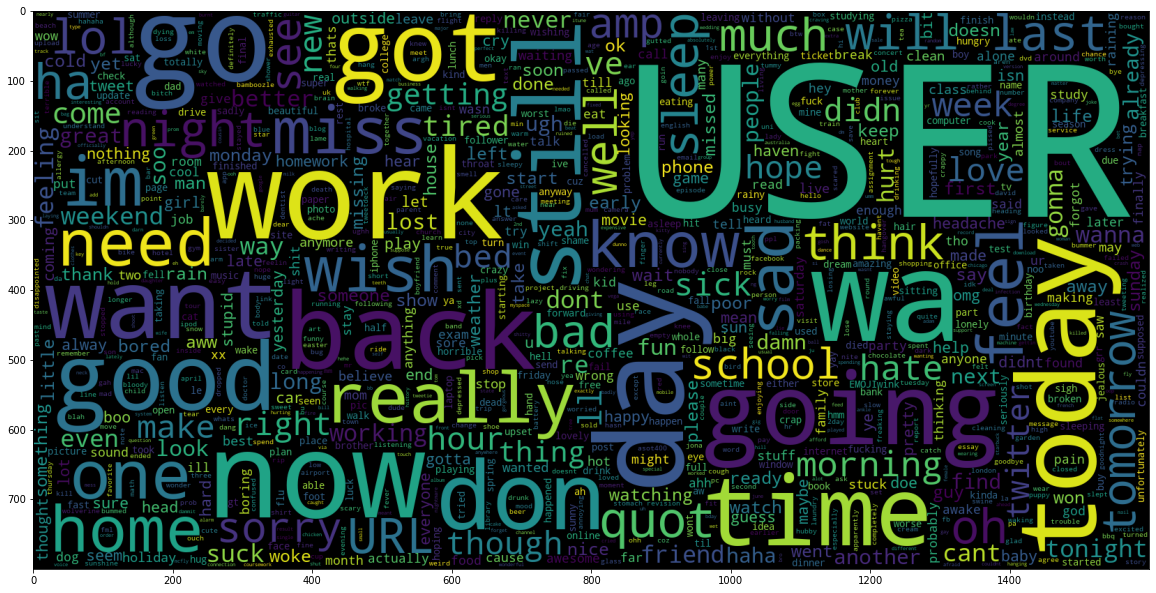

In [20]:
data_neg = processedtext[:80000]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000,
              width=1600,
              height=800,
              collocations=False).generate(" ".join(data_neg))
plt.imshow(wc);

### WordCloud for Positive Tweets

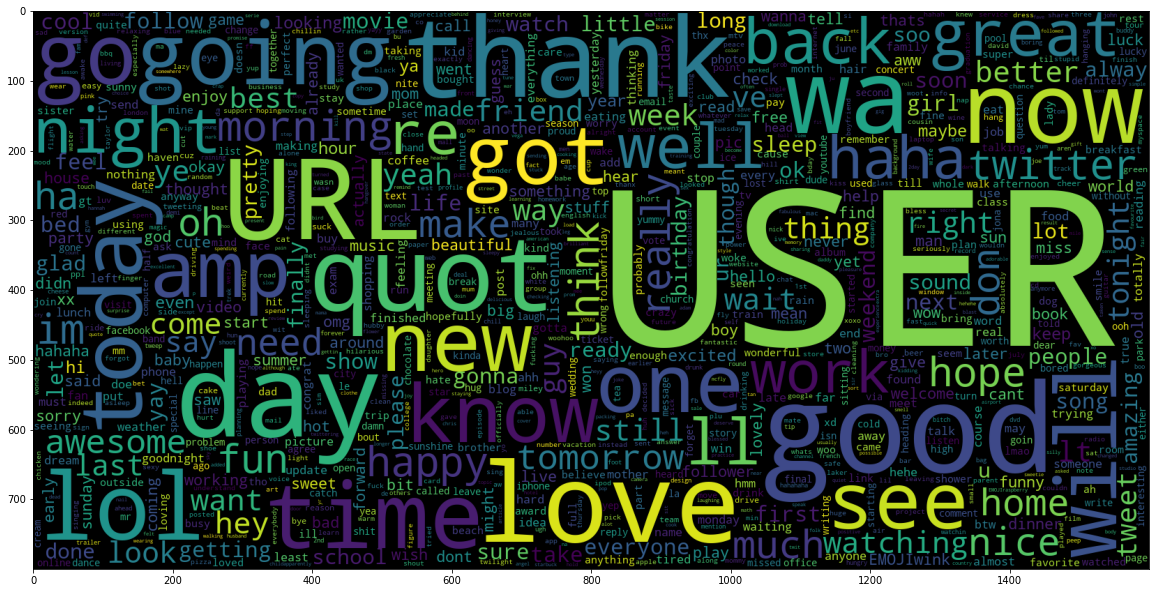

In [21]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words=1000,
              width=1600,
              height=800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize=(20,20))
plt.imshow(wc);

## Splitting the data

In [22]:
x_train, x_test, y_train, y_test = train_test_split(processedtext,
                                                   sentiment,
                                                   test_size=0.05,
                                                   random_state=0)

## TF-IDF Vectorizer
**TF-IDF indicates what the importance of the word is to undersand the data**.  Suppose you have a dataset where students write an essay on topic My House.  In the dataset, the word a appears many times; it is a high frequency word compared to other words in data.  The dataset contains other words like home, house, rooms, and so on but appear less often, so their frequency are lower and carry more information compared to a.   
  
**TF-IDF Vectorizer** converts collection of raw documents to a matrix of TF-IDF features.  The Vectorizer is usually trained on a training subset of data.  
  
**ngram_range** is the range of number of words in a sequence. E.g. "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2).
  
**max_features** specifies the number of features to consider.  Ordered by feature frequency across the corpus.

In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                            max_features=500000)
vectorizer.fit(x_train)
print(f'Vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

Vectorizer fitted.
No. of feature_words:  500000


## Transform the dataset
Transforming the train and test dataset into matrix of TF-IDF Features by using the TF-IDF Vectorizer.  This datasets will be used to train and test model.

In [24]:
x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test)
print(f'Data Transformed.')

Data Transformed.


## Creating models
Creating 2 models for analysis:
- Linear Support Classification (LinearSVC)
- Logistic Regression (LR)
Since dataset is not skewed, i.e. has equal number of positive and negative predictions.  We choose accuracy as evaluation metric.  We plot a **confusion matrix** to get a picture of both classification types

### Evaluation Function

In [27]:
def model_evaluate(model):
    
    # Predict values for Test
    y_pred = model.predict(x_test)
    
    # print evaluation metrics
    print(classification_report(y_test, y_pred))
    
    # Compute and plot confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix,
               annot=labels,
               cmap='Blues',
               fmt='',
               xticklabels=categories,
               yticklabels=categories)
    
    plt.xlabel("Predicted values", fontdict={'size':14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size':14}, labelpad=10)
    plt.title(f"{model} Confusion Matrix", fontdict={'size':18}, pad=20)

## LinearSVC Model

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



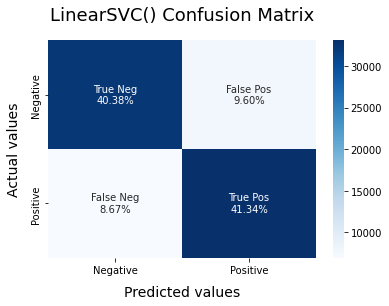

In [29]:
SVCModel = LinearSVC()
SVCModel.fit(x_train, y_train)
model_evaluate(SVCModel)

## Logistic Regression Model

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



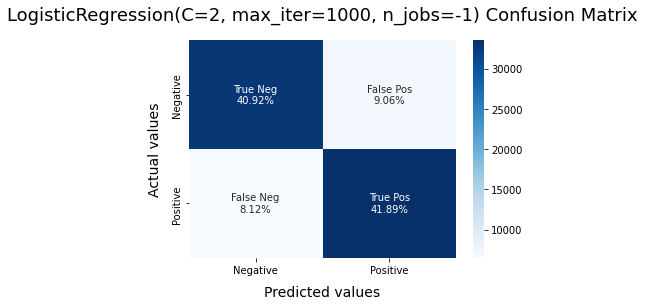

In [31]:
LRmodel = LogisticRegression(C=2,
                            max_iter=1000,
                            n_jobs=-1)
LRmodel.fit(x_train, y_train)
model_evaluate(LRmodel)

**Logistic Regression** performs best in terms of accuracy witg **83%** compared to **82%** from **LinearSVC**

## Saving Models
Using **PICKLE** to save models for later use

In [32]:
file = open('vectorizer-ngram-(1,2).pickle', 'wb')
pickle.dump(vectorizer,file)
file.close()

file = open('Sentiment-LR.pickle', 'wb')
pickle.dump(LRmodel, file)
file.close()

## Using Model
To use the model for sentiment prediction, need to import models using Pickle.  
The vectorizer can be used to transform data to matrix of TF-IDF features.  While the model can be used to predict the sentiment of the transformed text whose sentiment has to be predicted, however must be preprocessed.

In [35]:
def load_models():
    # Load vectorizer
    file = open('vectorizer-ngram-(1,2).pickle','rb')
    vectorizer = pickle.load(file)
    file.close()
    # Load LR model
    file = open('Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectorizer, LRmodel


def predict(vectorizer, model, text):
    # Predict Sentiment
    textdata = vectorizer.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert to Pandas Dataframe
    df = pd.DataFrame(data,
                     columns=['text','sentiment'])
    df = df.replace([0,1], ["negative", "positive"])
    return df


if __name__=="__main__":
    # Loading models
    vectorizer, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I feel like shit",
           "I am not feeling good today",
           "Mr. Stark, lets celebrate today"]
    df = predict(vectorizer, LRmodel, text)
    print(df.head())

                              text sentiment
0                 I feel like shit  negative
1      I am not feeling good today  negative
2  Mr. Stark, lets celebrate today  positive
